In [1]:
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
import torch_geometric.data as pyg_data

from motclass import MotDataset
from utilities import get_best_device

device = get_best_device()


[INFO] Using CUDA.


In [2]:
def draw_graph(graph, track):
	G = to_networkx(graph, to_undirected=True)

	n_sum = [0] + list(np.cumsum(track.n_nodes))

	for i, n in enumerate(track.n_nodes):
		for j in range(n):
			G.nodes[j + n_sum[i]]['level'] = i

	pos = nx.multipartite_layout(G, subset_key="level")

	nx.draw(G, pos=pos, with_labels=True)


In [6]:
mot20_path = '/media/dmmp/vid+backup/Data/MOT20/images'
mot20 = MotDataset(mot20_path, 'train', linkage_type="ADJACENT", device=device)


In [7]:
track = mot20[0]

adjacency_matrix, flattened_node_features, frame_times, edge_attr = track.get_data(limit=5)

graph = pyg_data.Data(
    detections=flattened_node_features,
    num_nodes=flattened_node_features.shape[0],
    times=frame_times,
    edge_index=adjacency_matrix.t().contiguous(),
    edge_attr=edge_attr,
        )


Processing frame #5 (000005.jpg):   1%|         | 4/429 [00:01<02:11,  3.23it/s]

[INFO] 6564 total edges


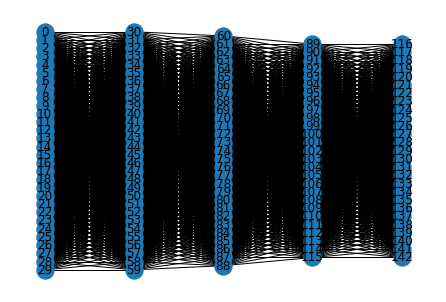

In [8]:

draw_graph(graph, track)

Processing frame #5 (000005.jpg):   0%|          | 4/2405 [00:00<03:44, 10.68it/s]


[INFO] 1956 total edges


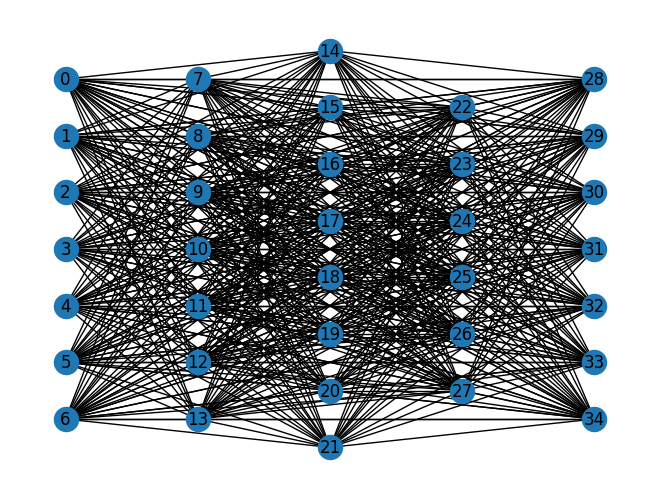

In [49]:
mot20 = MotDataset('data/MOT20', 'train', linkage_type=1, device=device)

track = mot20[0]

graph = track.get_data(limit=5)

draw_graph(graph, track)


---

In [8]:
mot20_path = '/media/dmmp/vid+backup/Data/MOT20/images'
mot20 = MotDataset(mot20_path, 'train', linkage_type="ADJACENT", device=device)

track = mot20[0]

track.get_data(limit=5)


Processing frame #5 (000005.jpg):   1%|         | 4/429 [00:01<02:05,  3.38it/s]

[INFO] 6564 total edges


(tensor([[ 30,   0],
         [  0,  30],
         [ 30,   1],
         ...,
         [114, 142],
         [142, 115],
         [115, 142]]),
 tensor([[[[ 87,  87,  87,  ..., 106, 106, 106],
           [ 87,  87,  87,  ..., 106, 106, 106],
           [ 87,  87,  87,  ..., 106, 106, 106],
           ...,
           [129, 129, 129,  ..., 128, 128, 128],
           [129, 129, 129,  ..., 128, 128, 128],
           [129, 129, 129,  ..., 128, 128, 128]],
 
          [[ 80,  80,  80,  ...,  99,  99,  99],
           [ 80,  80,  80,  ...,  99,  99,  99],
           [ 80,  80,  80,  ...,  99,  99,  99],
           ...,
           [116, 116, 116,  ..., 124, 124, 124],
           [116, 116, 116,  ..., 124, 124, 124],
           [116, 116, 116,  ..., 124, 124, 124]],
 
          [[ 70,  70,  70,  ...,  87,  87,  87],
           [ 70,  70,  70,  ...,  87,  87,  87],
           [ 70,  70,  70,  ...,  87,  87,  87],
           ...,
           [100, 100, 100,  ..., 121, 121, 121],
           [100, 100

---

In [11]:
# Average size of images in MOT datasets

from PIL import Image
import os

mot20_path = '/media/dmmp/vid+backup/Data/MOT20/images'
mot20tr = MotDataset(mot20_path, split='train', device=device)
# mot17tr = MotDataset('data/MOT17', split='train', device=device)
# mot15tr = MotDataset('data/MOT15', split='train', device=device)

def get_avg_size(motds):

	width = list()
	height = list()

	for track in motds:
		for f in os.listdir(track.img_dir):
			im = Image.open(os.path.join(track.img_dir,f))
			width.append(im.size[0])
			height.append(im.size[1])

	return tuple([(np.mean(width)), np.mean(height)])

print(get_avg_size(mot20))


(1620.1091703056768, 1026.1426491994177)
